In [1]:
# See https://github.com/tensorflow/tensorflow/issues/31249
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [202]:
tf.compat.v1.disable_eager_execution()

ValueError: tf.enable_eager_execution must be called at program startup.

In [2]:
batch_size=512
x2_dist=tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(batch_size)
x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                scale=tf.ones(batch_size, dtype=tf.float32))
x1_samples = x1.sample()
x_samples = tf.stack([x1_samples, x2_samples], axis=1)

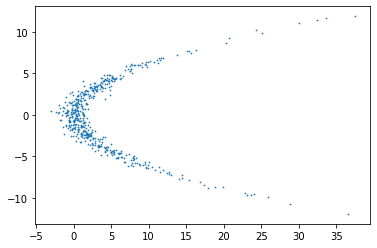

In [159]:
plt.scatter(x_samples[:,0], x_samples[:,1], s=.5)

In [283]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))

In [284]:
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=.5, validate_args=True, name="leaky_relu"):
        super().__init__(inverse_min_event_ndims=1, validate_args=validate_args, name=name)
        self.alpha = alpha
    
    def _forward(self, x):
        return tf.where(tf.greater_equal(x, 0), x, self.alpha * x)
    
    def _inverse(self, y):
        return tf.where(tf.greater_equal(y, 0), y, 1./ self.alpha*y)
    
    def _inverse_log_det_jacobian(self, y):
        I = tf.ones_like(y)
        J_inv = tf.where(tf.greater_equal(y, 0), I, 1/self.alpha * I)
        log_abs_det_j_inv = tf.math.log(tf.math.abs(J_inv))
        return tf.reduce_sum(log_abs_det_j_inv, axis=1)

In [285]:
optimizer = tf.keras.optimizers.Adam(1e-3)

In [273]:
var_list = []
d, r = 2, 2
DTYPE = tf.float32
num_layers = 6
for i in range(num_layers):
    print('bijector_{}'.format(i))
    V = tf.Variable(tf.compat.v1.glorot_uniform_initializer()([d, r]))
    shift = tf.Variable(tf.compat.v1.glorot_uniform_initializer()([d]))
    L = tf.Variable(tf.compat.v1.glorot_uniform_initializer()([int(d * (d+1)/2)]))
    alpha = tf.Variable(tf.compat.v1.glorot_uniform_initializer()([]))
    var_list.extend([V, shift, L, alpha])

bijector_0
bijector_1
bijector_2
bijector_3
bijector_4
bijector_5


In [286]:
def get_dist(var_list):
    bijectors = []
    for i in range(num_layers):
#         print("i: ", i)
        V = var_list[4*i]
        shift = var_list[4*i+1]
        L = var_list[4*i+2]
        alpha = var_list[4*i+3] + .1
        bijectors.append(tfb.Affine(
            scale_tril=tfd.fill_triangular(L),
            scale_perturb_factor=V,
            shift=shift,))
        bijectors.append(LeakyReLU(alpha=alpha))
    mlp_bijector = tfb.Chain(list(reversed(bijectors[:-1])), name='2d_mlp_bijector')
    dist = tfd.TransformedDistribution(
        distribution=base_dist,
        bijector=mlp_bijector
    )
    return dist

In [287]:
@tf.function
def train_step(x_samples):
    with tf.GradientTape() as tape:
        dist = get_dist(var_list)
        loss = -tf.reduce_mean(dist.log_prob(x_samples))
    print("loss: ", loss)
    gradients = tape.gradient(loss, var_list)
    print("?gradients: ", gradients[:-1])
    optimizer.apply_gradients(zip(gradients[:-1], var_list[:-1]))

In [288]:
import time

In [295]:
-tf.reduce_mean(get_dist(var_list).log_prob(x_samples))

<tf.Tensor: id=958008, shape=(), dtype=float32, numpy=4.4140015>

In [290]:
start_time = time.time()
train_step(x_samples)
print(time.time() - start_time)

loss:  Tensor("Neg:0", shape=(), dtype=float32)
?gradients:  [<tf.Tensor 'AddN_3:0' shape=(2, 2) dtype=float32>, <tf.Tensor 'Reshape_111:0' shape=(2,) dtype=float32>, <tf.Tensor 'AddN_8:0' shape=(3,) dtype=float32>, <tf.Tensor 'AddN_7:0' shape=() dtype=float32>, <tf.Tensor 'AddN_12:0' shape=(2, 2) dtype=float32>, <tf.Tensor 'Reshape_133:0' shape=(2,) dtype=float32>, <tf.Tensor 'AddN_17:0' shape=(3,) dtype=float32>, <tf.Tensor 'AddN_16:0' shape=() dtype=float32>, <tf.Tensor 'AddN_21:0' shape=(2, 2) dtype=float32>, <tf.Tensor 'Reshape_155:0' shape=(2,) dtype=float32>, <tf.Tensor 'AddN_26:0' shape=(3,) dtype=float32>, <tf.Tensor 'AddN_25:0' shape=() dtype=float32>, <tf.Tensor 'AddN_30:0' shape=(2, 2) dtype=float32>, <tf.Tensor 'Reshape_177:0' shape=(2,) dtype=float32>, <tf.Tensor 'AddN_35:0' shape=(3,) dtype=float32>, <tf.Tensor 'AddN_34:0' shape=() dtype=float32>, <tf.Tensor 'AddN_39:0' shape=(2, 2) dtype=float32>, <tf.Tensor 'Reshape_199:0' shape=(2,) dtype=float32>, <tf.Tensor 'AddN_44

In [291]:
NUM_STEPS = 30_000
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    if i%5000 == 0:
        print(i)
    train_step(x_samples)

0
5000
10000
15000
20000
25000


In [292]:
dist = get_dist(var_list)
res = dist.sample(5120)

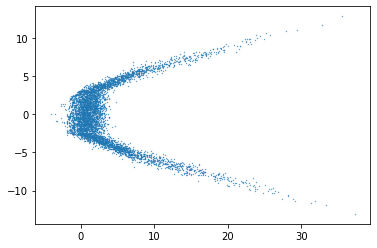

In [293]:
plt.scatter(res[:,0], res[:,1], s=.1)

In [276]:
# visualization
x = base_dist.sample(512)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

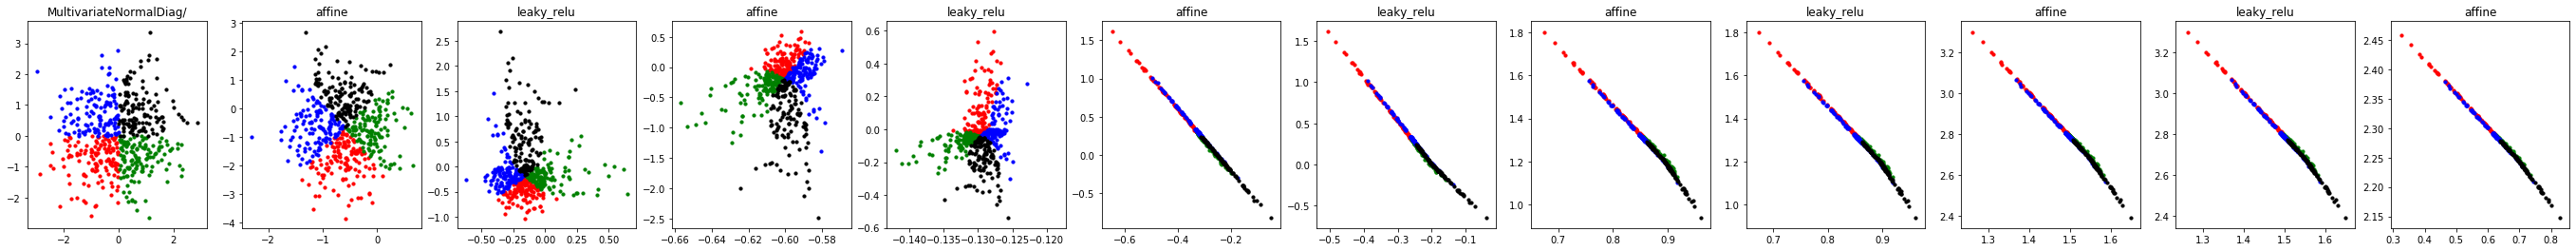

In [277]:
results = samples
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0].numpy()
for i in range(len(results)):
    X1 = results[i].numpy()
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
#     arr[i].set_xlim([-2, 2])
#     arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])